In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import random

In [2]:
# load data
# data contains 5 year historical data for ATVI
df = pd.read_csv('ATVI.csv')

In [3]:
display(df.head(5),df.tail(5))

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-05-11,25.000000,25.059999,24.620001,24.639999,23.818539,5685800
1,2015-05-12,24.540001,24.680000,24.270000,24.610001,23.789537,5982000
2,2015-05-13,24.799999,24.969999,24.580000,24.629999,23.808870,3733700
3,2015-05-14,24.790001,25.280001,24.719999,25.170000,24.330868,5667000
4,2015-05-15,25.320000,25.660000,25.150000,25.420000,24.572535,8220100


,Date,Open,High,Low,Close,Adj Close,Volume
1239,2020-04-13,60.320000,63.000000,60.020000,62.750000,62.340000,8054700
1240,2020-04-14,63.980000,64.000000,62.720001,63.279999,63.279999,7156400
1241,2020-04-15,62.630001,66.059998,62.250000,65.709999,65.709999,9411300
1242,2020-04-16,66.449997,68.320000,65.550003,68.050003,68.050003,11276000
1243,2020-04-17,66.500000,67.000000,64.889999,66.879997,66.879997,10942300


/Users/yashu/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


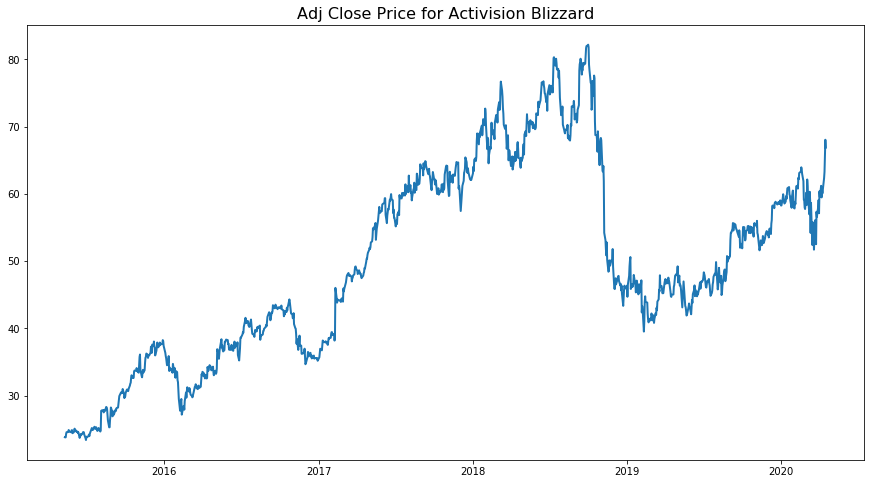

In [4]:
# plot data
plt.figure(figsize=(15,8))
plt.plot(pd.to_datetime(df.Date), df['Adj Close'],lw=2)
plt.title('Adj Close Price for Activision Blizzard', fontsize = 16)
plt.show()

In [5]:
# define bootstrap methods

def ErrGenerator(err):
    """
    This function is used to generate bootstrapped error array
    Input:
    err: list/array
    """
    new_err = []
    n = len(err)
    for i in range(n):
        new_err.append(err[round(random.uniform(0,n-1))])
    return new_err
        
def PriceGenerator(P0, ret):
    """
    This function is used to generate new price samples
    Input:
    P0: float/int, initial price
    ret: list/array of return
    """
    price_list = [P0]
    for item in ret:
        price_list.append(price_list[-1]*np.exp(item))
    return price_list


In [6]:
def BootStrap(df,N):
    """
    This function is used to generate dataframe of price and N bootstrapped price samples
    Input:
    df: dataframe, must contain column 'Adj Close'
    N: int, number of simulation needed

    - Step 1: estimate alpha and beta
    - Step 2: calculate residuals
    - Step 3: create new sample with bootstrapped residuals
    - Step 4: compile new price samples
    """
    
    # create a new dataframe for stock prices
    price_df = pd.DataFrame(df['Adj Close'][1:]).reset_index(drop=True)
    price_df = price_df.rename(columns = {'Adj Close':'Empirical'})
    
    # calculate log returns
    log_ret = np.log(df['Adj Close']).diff(1).values
    ret_t = log_ret[2:].reshape(-1,1)
    ret_t_1 = log_ret[1:-1].reshape(-1,1)

    #plug returns in the linear regression model
    model = LinearRegression()
    model.fit(ret_t_1,ret_t)
    alpha = model.intercept_
    beta = model.coef_

    # calculate the error
    err = (ret_t - alpha - ret_t_1 * beta).flatten()
    err_lenth = len(err)
    
    # generate new prices
    for i in range(N+1):
        # bootstrap error term
        new_err = ErrGenerator(err)
        # calculate returns
        new_ret = new_err + (alpha + ret_t_1*beta).flatten()
        # append bootstrapped price
        price_df['B{}'.format(i)] = PriceGenerator(price_df['Empirical'][0],new_ret)
    return price_df

In [7]:
# generate 1000 new price samples
random.seed(30)
price_df = BootStrap(df,1000)
# price_df = price_df.set_index(pd.to_datetime(df.Date[1:]))

In [8]:
price_df.head(5)

,Empirical,B0,B1,B2,B3,B4,B5,B6,B7,B8,...,B991,B992,B993,B994,B995,B996,B997,B998,B999,B1000
0,23.789537,23.789537,23.789537,23.789537,23.789537,23.789537,23.789537,23.789537,23.789537,23.789537,...,23.789537,23.789537,23.789537,23.789537,23.789537,23.789537,23.789537,23.789537,23.789537,23.789537
1,23.808870,23.943103,23.517046,24.462256,24.078112,23.456348,23.276965,23.927137,24.121462,23.876857,...,23.675120,25.070849,23.879356,24.019934,23.333917,24.177095,25.537910,21.809125,23.220024,24.062164
2,24.330868,23.869362,23.775489,24.475562,24.221332,23.469426,23.389142,24.635850,24.409482,24.255466,...,23.367669,24.889116,24.032663,23.999939,23.726571,24.419833,25.215316,21.786790,23.335220,24.452321
3,24.572535,24.059400,23.615510,25.049377,24.709423,23.140114,23.202023,25.022041,24.555886,24.917980,...,23.179282,26.661805,24.271072,24.066777,23.946783,24.697192,25.289299,22.028664,23.716489,24.703800
4,24.572535,23.946400,24.189778,25.119451,24.511486,22.850651,23.633050,25.479982,24.093952,25.547040,...,23.180682,26.738143,24.254892,24.361021,23.699598,24.700000,27.312701,22.201146,23.827124,24.398342


# Strategy: MACD

In [9]:
def SMA(price,n):
    """
    This function is used to get simple moving average with lag n
    Inputs:
    price: list/array
    n: int, lag for SMA
    """
    SMA = [None]*len(price)
    for i in range(n,len(price),1):
        SMA[i] = np.mean(price[i-n:i])
    return SMA

def EMA(price,n):
    """
    This function is used to get exponential moving average with lag n
    Inputs:
    price: list/array
    n: int, lag for EMA
    """
    EMA = [None]*len(price)
    EMA[n]=np.mean(price[0:n])
    beta = 2/(n+1)
    for i in range(n+1,len(price),1):
        EMA[i] = beta*price[i] + (1-beta)*EMA[i-1]
    return EMA

def MaxDrawdown(price):
    """
    This function is used to calculate the maximum drawdown of certain price series
    Input:
    price: list/array
    """
    pmax=0
    pmin=0
    drawdown=0
    for i in range(1,len(price)):
        pmax = price[:i].max()
        pmin = price[i:].min()
        drawdown = max(drawdown,pmax-pmin)
    return round(drawdown/pmax*100,2)
    

In [10]:
def MACD(price, time, st, lt, sig_t):
    """
    This function is used to implement MACD stategy on certain price series
    Inputs:
    price: list/array
    time: list/array, time index
    st: int, lag for short term EMA
    lt: int, lag for long term EMA
    sig_t: int, lag for signal line
    Output:
    total return, # total trade, % winning trade
    """
    # calculate macd line and signal line
    macd = np.array(EMA(price,st)[40:])- np.array(EMA(price,lt)[40:])
    sign = np.array(EMA(macd,sig_t))
    
    # cut all lines
    macd=macd[20:]
    sign=sign[20:]
    time=time[60:]
    
    buy = None
    temp = None
    trade = [[time[0],time[0],0]]
    ret = 0
    profit = 0
    beat = 0
    miss = 0
    for i in range(1,len(macd)):
        # buy when macd cross signal line from below
        if (macd[i]>sign[i]) and (macd[i-1]<sign[i-1]):
            buy = i
            temp = price[i]
        # sell when macd cross signal line from above
        elif (macd[i]<sign[i]) and (macd[i-1]>sign[i-1]):
            if buy and buy != trade[-1][0] and buy not in time[i-2:i]:
                ret = np.log(price[i])-np.log(temp)
                trade.append([buy,i,ret])
                profit = profit+ret
                if ret >= 0:
                    beat +=1
                else: 
                    miss +=1
    
    # could return the detail of trades if needed
    trade = trade[1:]
    return round(profit*100,2), len(trade), round(beat*100/len(trade),2)

In [11]:
cols = ['Total Return %','Total Trades','% winning trades','% Max Drawdown']
result_df = pd.DataFrame(columns=cols)
time = df.Date[1:].values

Profit = []
Num_trades = []
Beating_rate = []
Max_drawdown = []

st=12
lt=26
sig_t=9

for case in range(price_df.shape[1]):
    price = price_df.iloc[:,[case]].values.flatten()
    profit, num_trades, beating_rate = MACD(price, time, st, lt, sig_t)
    
    Profit.append(profit)
    Num_trades.append(num_trades)
    Beating_rate.append(beating_rate)
    Max_drawdown.append(MaxDrawdown(price))

Profit.append(round(np.mean(Profit),2))
Num_trades.append(round(np.mean(Num_trades),2))
Beating_rate.append(round(np.mean(Beating_rate),2))
Max_drawdown.append(round(np.mean(Max_drawdown),2))
    
index_name = np.append(price_df.columns.values,'Average')
result_df['Total Return %']=Profit
result_df['Total Trades']=Num_trades
result_df['% winning trades']=Beating_rate
result_df['% Max Drawdown'] = Max_drawdown
result_df = result_df.set_index(index_name)

In [12]:
display(result_df.head(5),result_df.tail(5))

,Total Return %,Total Trades,% winning trades,% Max Drawdown
Empirical,46.67,40.0,65.00,51.90
B0,151.13,43.0,69.77,21.29
B1,106.81,46.0,56.52,21.54
B2,51.35,47.0,59.57,14.97
B3,32.60,54.0,59.26,20.73


,Total Return %,Total Trades,% winning trades,% Max Drawdown
B997,2.10,48.00,56.25,41.49
B998,45.64,47.00,53.19,26.48
B999,-47.99,60.00,41.67,51.06
B1000,178.89,53.00,66.04,16.25
Average,37.55,46.34,55.66,36.00


In [13]:
from scipy.stats import norm

def Fit_normal(returns):
    """
    This function is used to fit the returns with normal distribution
    Input: 
    returns: list/array, returns
    """    
    # Fit a normal distribution to the data:
    mu, std = norm.fit(returns)

    # Plot the histogram.
    plt.hist(returns, bins=30, density=True, alpha=0.6, color='lightcoral')

    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)

    plt.show()
    
    return mu,std
    

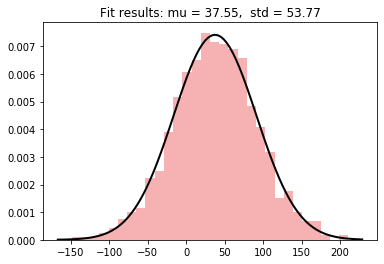

(37.55280439121757, 53.76948892393695)

In [14]:
Fit_normal(result_df['Total Return %'][:-1])

# Improvement: take price action into account

In [15]:
def Improved_MACD(price, time, st, lt, sig_t):
    """
    This function is used to implement the improced MACD stategy on certain price series
    Inputs:
    price: list/array
    time: list/array, time index
    st: int, lag for short term EMA
    lt: int, lag for long term EMA
    sig_t: int, lag for signal line
    Output:
    total return, # total trade, % winning trade
    """
    # calculate macd line and signal line
    macd = np.array(EMA(price,st)[40:])- np.array(EMA(price,lt)[40:])
    sign = np.array(EMA(macd,sig_t))
    
    # cut all lines
    macd=macd[20:]
    sign=sign[20:]
    time=time[60:]
    
    buy = None
    temp = None
    trade = [[time[0],time[0],0]]
    ret = 0
    profit = 0
    beat = 0
    miss = 0
    for i in range(2,len(macd)):
        # buy when macd cross signal line from below
        if (macd[i]>sign[i]) and (macd[i-1]<sign[i-1]):
            buy = i
            temp = price[i]
        # sell when macd lower than signal line and the price start decreasing
        elif macd[i]<sign[i] and price[i]<price[i-1] and price[i-1]>price[i-2]:
            if buy and buy != trade[-1][0] and buy not in time[i-2:i]:
                ret = np.log(price[i])-np.log(temp)
                trade.append([buy,i,ret])
                profit = profit+ret
                if ret >= 0:
                    beat +=1
                else: 
                    miss +=1
    
    # could return the detail of trades if needed
    trade = trade[1:]
    return round(profit*100,2), len(trade), round(beat*100/len(trade),2)
            

In [16]:
cols = ['Total Return %','Total Trades','% winning trades','% Max Drawdown']
improve_df = pd.DataFrame(columns=cols)
time = df.Date[1:].values

Profit = []
Num_trades = []
Beating_rate = []
Max_drawdown = []

st=12
lt=26
sig_t=9

for case in range(price_df.shape[1]):
    price = price_df.iloc[:,[case]].values.flatten()
    profit, num_trades, beating_rate = Improved_MACD(price, time, st, lt, sig_t)
    
    Profit.append(profit)
    Num_trades.append(num_trades)
    Beating_rate.append(beating_rate)
    Max_drawdown.append(MaxDrawdown(price))

Profit.append(round(np.mean(Profit),2))
Num_trades.append(round(np.mean(Num_trades),2))
Beating_rate.append(round(np.mean(Beating_rate),2))
Max_drawdown.append(round(np.mean(Max_drawdown),2))
    
index_name = np.append(price_df.columns.values,'Average')
improve_df['Total Return %']=Profit
improve_df['Total Trades']=Num_trades
improve_df['% winning trades']=Beating_rate
improve_df['% Max Drawdown'] = Max_drawdown
improve_df = improve_df.set_index(index_name)

In [17]:
display(improve_df.head(5),improve_df.tail(5))

,Total Return %,Total Trades,% winning trades,% Max Drawdown
Empirical,39.07,33.0,66.67,51.90
B0,161.44,39.0,71.79,21.29
B1,163.62,40.0,65.00,21.54
B2,56.92,39.0,53.85,14.97
B3,35.90,44.0,54.55,20.73


,Total Return %,Total Trades,% winning trades,% Max Drawdown
B997,24.80,39.0,56.41,41.49
B998,21.17,41.0,53.66,26.48
B999,16.56,52.0,44.23,51.06
B1000,150.73,44.0,65.91,16.25
Average,37.27,40.2,54.74,36.00


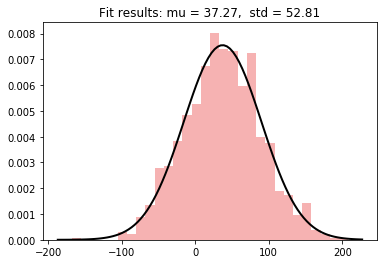

(37.27344311377245, 52.81496618870667)

In [18]:
Fit_normal(improve_df['Total Return %'][:-1])